In [0]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(X_train.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [0]:
# Preprocessing

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [0]:
# Set the dimensions of the noise
z_dim = 100

In [0]:
# Generator
adam = Adam(lr=0.0002, beta_1=0.5)

g = Sequential()
g.add(Dense(7*7*112, input_dim=z_dim))
g.add(Reshape((7, 7, 112)))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
g.add(Conv2DTranspose(56, 5, strides=2, padding='same'))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
g.add(Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid'))
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
g.summary()

d = Sequential()
d.add(Conv2D(56, 5, strides=2, padding='same', input_shape=(28, 28, 1), activation=LeakyReLU(alpha=0.2)))
d.add(Conv2D(112, 5, strides=2, padding='same'))
d.add(BatchNormalization())
d.add(Activation(LeakyReLU(alpha=0.2)))
d.add(Conv2D(224, 5, strides=2, padding='same'))
d.add(Activation(LeakyReLU(alpha=0.2)))
d.add(Flatten())
d.add(Dense(112, activation=LeakyReLU(alpha=0.2)))
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
d.summary()

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
gan.summary()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5488)              554288    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 112)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 112)         448       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 112)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 56)        156856    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 56)        224       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 56)       

In [0]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(generated_images.shape[0], 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}
samples = []

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            image_batch = image_batch.reshape(image_batch.shape[0], image_batch.shape[1], image_batch.shape[2], 1)
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            samples.append(generated_images)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


--------------- Epoch 1 ---------------


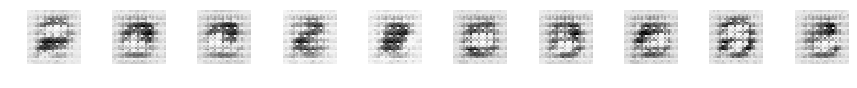

--------------- Epoch 20 ---------------


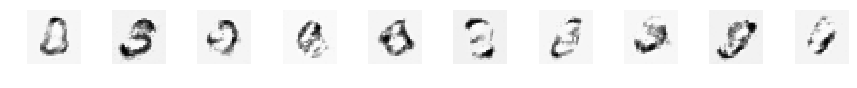

--------------- Epoch 40 ---------------


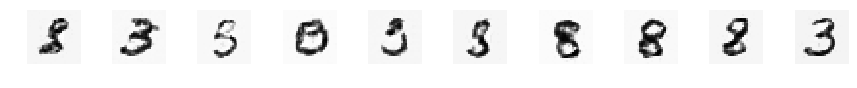

--------------- Epoch 60 ---------------


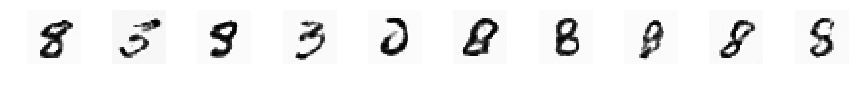

--------------- Epoch 80 ---------------


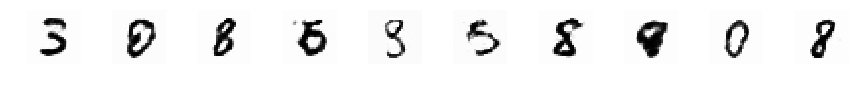

--------------- Epoch 100 ---------------


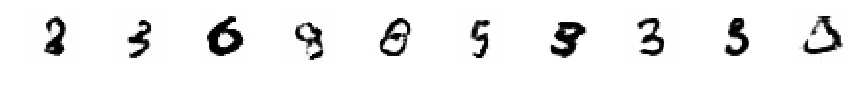

--------------- Epoch 120 ---------------


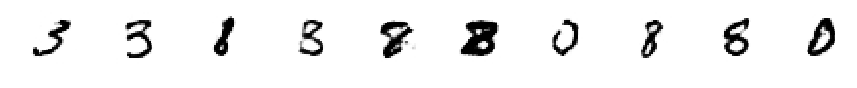

In [0]:
train(epochs=200, plt_frq=20, BATCH_SIZE=128)